In [1]:
# general imports for project
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# res net 50
from keras.applications.resnet50 import ResNet50, preprocess_input as res50_preprocess, decode_predictions

# inception v3
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess

# xception
from keras.applications.xception import Xception, preprocess_input as xception_preprocess


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier


# "Sequential" model lets us to define a stack of neural network layers
from keras.models import Sequential, Model

# import the "core" layers:
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer, Input, Lambda

# CNN
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# import some utilities to transform our data
from keras.utils import np_utils

# relative path
DATA_FILES_PATH = './testData/'

# image size tuple
IMAGE_SIZE = (128, 128, 3)

Using TensorFlow backend.


# Read the csv to get the labels for the photos
- we will then map the relative filepath and which dataset the file is in into the original dataframe for later use


In [2]:
# loading labels.csv
LABELS = pd.read_csv(os.path.join(DATA_FILES_PATH, 'labels.csv'))

# get the actual filepaths from the id
def map_filepath_to_df(base_path, label_df):
    train_names = set(os.listdir(f'{DATA_FILES_PATH}train/'))
    test_names = set(os.listdir(f'{DATA_FILES_PATH}train/'))
    label_df['image_path'] = [
        f'{DATA_FILES_PATH}train/{row["id"]}.jpg' if
        f'{row["id"]}.jpg' in train_names else
        f'{DATA_FILES_PATH}test/{row["id"]}.jpg'
        for index, row
        in label_df.iterrows()
    ]
    

map_filepath_to_df(DATA_FILES_PATH, LABELS)

# describe the dataset
LABELS.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./testData/train/000bec180eb18c7604dcecc8fe0db...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./testData/train/001513dfcb2ffafc82cccf4d8bbab...
2,001cdf01b096e06d78e9e5112d419397,pekinese,./testData/train/001cdf01b096e06d78e9e5112d419...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./testData/train/00214f311d5d2247d5dfe4fe24b23...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./testData/train/0021f9ceb3235effd7fcde7f7538e...


# Let's describe the dataset

In [3]:
LABELS.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=True).describe()


,id,image_path
count,120.000000,120.000000
mean,85.183333,85.183333
std,13.298122,13.298122
min,66.000000,66.000000
25%,75.000000,75.000000
50%,82.000000,82.000000
75%,91.250000,91.250000
max,126.000000,126.000000


# Lets take a look at the breed distribution
- here Scottish Deerhound is shown the most and Briard is shown the least

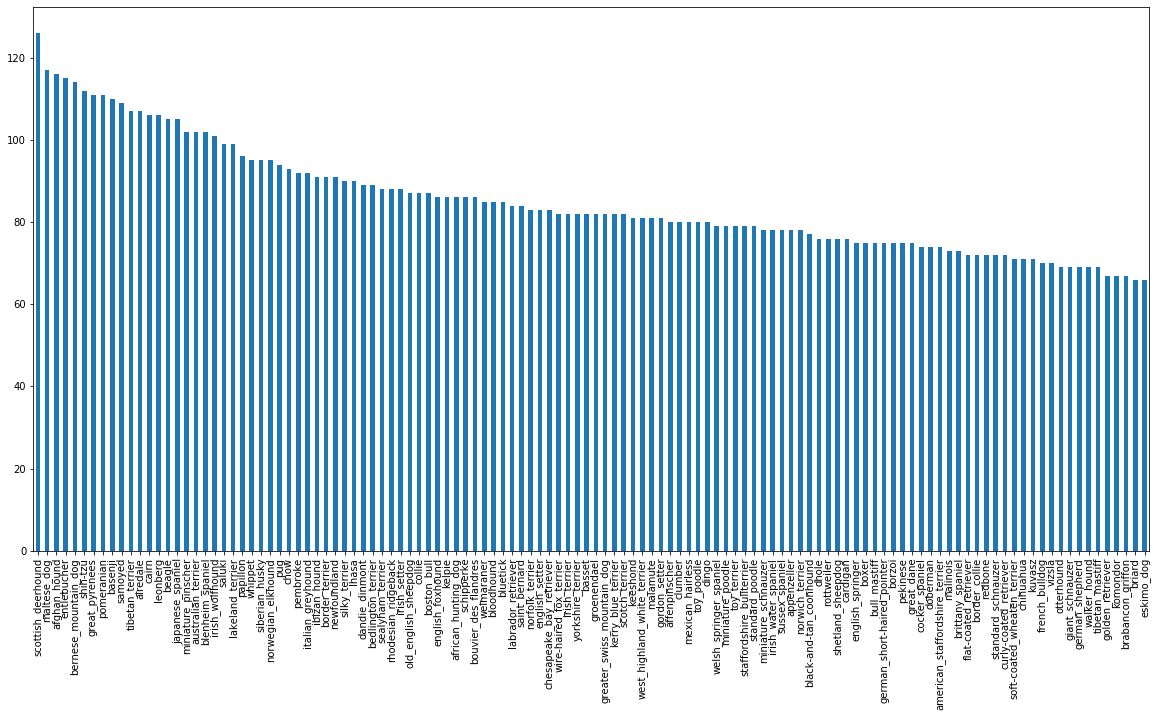

In [4]:
LABELS["breed"].value_counts().plot.bar(figsize=(20, 10))

# we can take a look at some of the images produced by load_image
- we will use load image later to produce a nparray of images


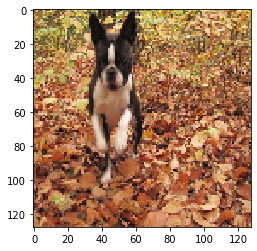

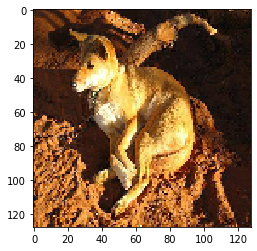

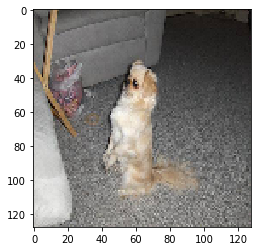

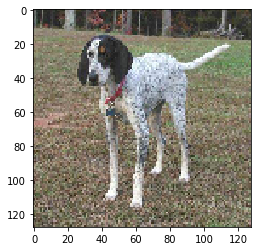

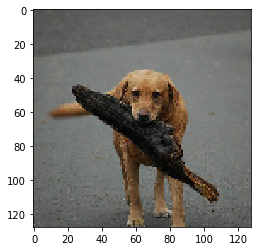

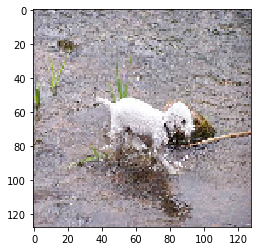

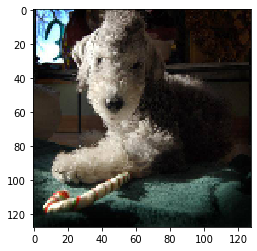

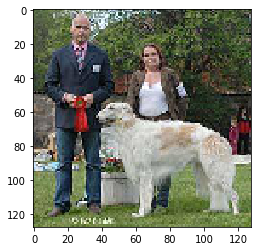

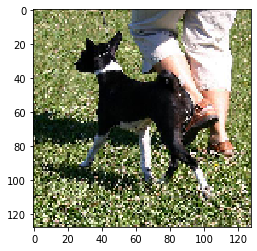

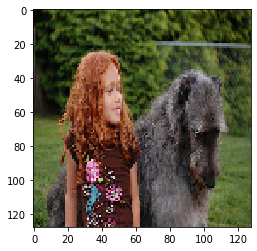

In [5]:
%matplotlib inline

for index, row in LABELS[:10].iterrows():
    plt.imshow(load_img(row['image_path'], target_size=IMAGE_SIZE))
    plt.show()

# first we need to load the images into the dataframe as image arrays, we can use img_to_array and load_image
- since we placed all the filepaths in the dataframe, we can do this is in a list comprehension 
np.expand_dims is used because 4d shaped is expected (num_images, width, height, num_channels). Our images will have
the shape (1, 224, 224, 3)
- the images can then be saved finally as a single vstack for train and test which will produce a shape of (num_samples, 224, 224, 3)

In [6]:
def get_X_y():
    image_filenames = LABELS['image_path']
    label_values = LABELS['breed']
    num_images = len(image_filenames)
    breeds = sorted(list(set(label_values)))
    class_to_num = dict(zip(breeds, range(len(breeds))))
    X = np.zeros([num_images, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]], dtype=np.uint8)
    y = np.zeros([num_images, 1], dtype=np.uint8)
    for i, file_path in enumerate(image_filenames):
        X[i] = load_img(file_path, target_size=IMAGE_SIZE)
        y[i] = class_to_num[label_values[i]]
    return X, np_utils.to_categorical(y)

X, y = get_X_y()

print(X.shape)
print(y.shape)

(10222, 128, 128, 3)
(10222, 120)


# since we would like to test our accuracy let's create a test and train subsection


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)

(8177, 128, 128, 3)
(2045, 128, 128, 3)


# now lets create a base CNN model to use based off of our dataset
    

In [8]:
def get_model():
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=IMAGE_SIZE))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(120, activation='softmax'))

    return model
    
my_cnn = get_model()

# compile the model

In [9]:
my_cnn.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer='adam')

print(my_cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)       

# fit the model

In [10]:
checkpointer = ModelCheckpoint(filepath='./saved_models/my_cnn_best_weights.hdf5', verbose=1, save_best_only=True)

# early stopping callback
early_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# history = model.fit(X_train, y_train, batch_size=32, epochs=3, verbose=1)
# epochs: Number of iteration over the entire x and y data provided. 
# epochs: Number of iteration over the entire x and y data provided. 
# epochs: Number of iteration over the entire x and y data provided. 
# epochs: Number of iteration over the entire x and y data provided. 
# verbose: 0, 1, or 2. how want to see the training progress. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. 
# You can add some callbacks to get a view on internal states and statistics of the model during training:
# https://keras.io/callbacks/

history = my_cnn.fit(X_train, y_train, validation_split=.15, epochs=50, batch_size=128, callbacks=[checkpointer, early_callback], verbose=1)

Train on 6950 samples, validate on 1227 samples
Epoch 1/50
6950/6950 [==============================] - 41s 6ms/step - loss: 28.6087 - accuracy: 0.0085 - val_loss: 4.7847 - val_accuracy: 0.0098

Epoch 00001: val_loss improved from inf to 4.78466, saving model to ./saved_models/my_cnn_best_weights.hdf5
Epoch 2/50
6950/6950 [==============================] - 39s 6ms/step - loss: 4.7853 - accuracy: 0.0081 - val_loss: 4.7838 - val_accuracy: 0.0130

Epoch 00002: val_loss improved from 4.78466 to 4.78383, saving model to ./saved_models/my_cnn_best_weights.hdf5
Epoch 3/50
6950/6950 [==============================] - 39s 6ms/step - loss: 4.7782 - accuracy: 0.0131 - val_loss: 4.7798 - val_accuracy: 0.0081

Epoch 00003: val_loss improved from 4.78383 to 4.77979, saving model to ./saved_models/my_cnn_best_weights.hdf5
Epoch 4/50
6950/6950 [==============================] - 38s 6ms/step - loss: 4.7559 - accuracy: 0.0194 - val_loss: 4.7688 - val_accuracy: 0.0130

Epoch 00004: val_loss improved from

# load the best weights and test accuracy from best weights


In [11]:
my_cnn.load_weights('./saved_models/my_cnn_best_weights.hdf5')

predictions = my_cnn.predict_classes(X_test)
score = my_cnn.evaluate(X_test, y_test, verbose=1)
print('The accuracy is: ', score[1])

2045/2045 [==============================] - 4s 2ms/step
The accuracy is: 0.018092909827828407


# plot out progress

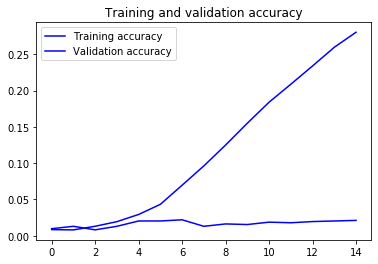

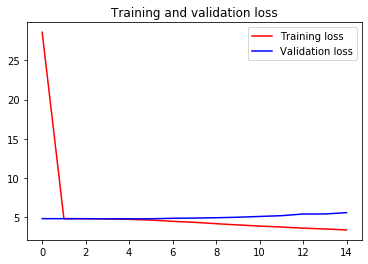

In [12]:
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# the accuracy is not too great here, could be due to a low amount of images.
- our next step would be to use a image generator to generate new images from our existing images by performing transformations on them
- this includes flipping the image, etc.

In [13]:
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

dataset_train = gen.flow(X_train, y_train, batch_size=20, subset='training')
dataset_val = gen.flow(X_train, y_train, batch_size=20, subset='validation')

new_cnn = get_model()

# compile
new_cnn.compile(loss='categorical_crossentropy',metrics=['accuracy'],
              optimizer='adam')

checkpointer = ModelCheckpoint(filepath='./saved_models/new_cnn_best_weights.hdf5', verbose=1, save_best_only=True)

# history = model.fit(X_train, y_train, batch_size=32, epochs=3, verbose=1)
new_history = new_cnn.fit_generator(dataset_train, validation_data=dataset_val, steps_per_epoch=len(dataset_train)//32, epochs=20, callbacks=[checkpointer], verbose=1, validation_steps = len(dataset_val)//32)



Epoch 1/20
9/9 [==============================] - 3s 383ms/step - loss: 5.1906 - accuracy: 0.0167 - val_loss: 4.7729 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.77293, saving model to ./saved_models/new_cnn_best_weights.hdf5
Epoch 2/20
9/9 [==============================] - 2s 191ms/step - loss: 4.7947 - accuracy: 0.0111 - val_loss: 4.8160 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 4.77293
Epoch 3/20
9/9 [==============================] - 2s 186ms/step - loss: 4.7890 - accuracy: 0.0111 - val_loss: 4.7937 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 4.77293
Epoch 4/20
9/9 [==============================] - 2s 200ms/step - loss: 4.8008 - accuracy: 0.0056 - val_loss: 4.7879 - val_accuracy: 0.0167

Epoch 00004: val_loss did not improve from 4.77293
Epoch 5/20
9/9 [==============================] - 2s 197ms/step - loss: 4.7882 - accuracy: 0.0167 - val_loss: 4.7900 - val_accuracy: 0.0000e+00

Epoch 00005: val_

# plot out the results

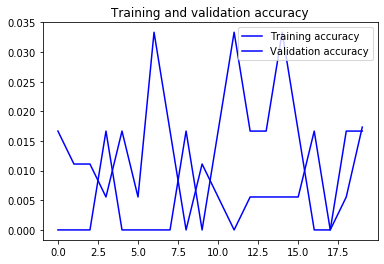

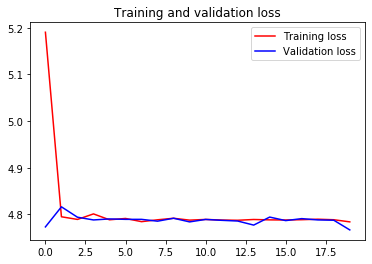

In [14]:
%matplotlib inline

accuracy = new_history.history['accuracy']
val_accuracy = new_history.history['val_accuracy']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Our next best shot is to use transfer learning from a prebuild model in keras
- our previous model was all over the place and prone to overfitting
- this should cut down training time and increase our accuracy
- we chose to use ResNet50 with the imagenet weights since it can already predict quite a few dog breeds
  - this requires getting the bottleneck features of the resnet 50 model using our dataset
  - bottleneck features are the high level features generated by a model without the top layers (what gets sent into the dense layers)

In [15]:
# generic feature extractpr
def feature_extractor(model_function, preprocess_function, input_size, data):
    input_layer = Input(input_size)
    preprocessor = Lambda(preprocess_function)(input_layer)
    base_model = model_function(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    return feature_maps

res50_features = feature_extractor(ResNet50, res50_preprocess, (128, 128, 3), X_train)
res50_test_features = feature_extractor(ResNet50, res50_preprocess, (128, 128, 3), X_test)
np.save('./extracted_features/res50_features.npy', res50_features)
np.save('./extracted_features/res50_test_features.npy', res50_test_features)


2045/2045 [==============================] - 207s 101ms/step


# Create the extended model from the resnet bottlenecks

In [23]:
res50_features = np.load('./extracted_features/res50_features.npy')
res50_test_features = np.load('./extracted_features/res50_test_features.npy')

print(res50_features.shape)

def get_resnet50_model():
    model = Sequential()
    model.add(InputLayer(input_shape=res50_features.shape[1:]))
    model.add(Dropout(0.5))
    model.add(Dense(520, activation='relu'))
    model.add(Dense(120, activation='softmax'))
    return model


my_Resnet50 = get_resnet50_model()

(8177, 2048)


# compile the model

In [24]:
my_Resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(my_Resnet50.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 520)               1065480   
_________________________________________________________________
dense_7 (Dense)              (None, 120)               62520     
Total params: 1,128,000
Trainable params: 1,128,000
Non-trainable params: 0
_________________________________________________________________
None


# fit the res net 50 model
- use a checkpointer like before to save the best weights

In [43]:
checkpoint_50 = ModelCheckpoint(filepath='./saved_models/resnet50_best_weights.hdf5', verbose=1, save_best_only=True)

history = my_Resnet50.fit(res50_features, y_train, validation_split=.15, epochs=300, batch_size=60, callbacks=[checkpoint_50, early_callback], verbose=1)

Train on 6950 samples, validate on 1227 samples
Epoch 1/300
6950/6950 [==============================] - 3s 465us/step - loss: 1.0212 - accuracy: 0.6918 - val_loss: 1.8270 - val_accuracy: 0.5134

Epoch 00001: val_loss improved from inf to 1.82702, saving model to ./saved_models/resnet50_best_weights.hdf5
Epoch 2/300
6950/6950 [==============================] - 3s 428us/step - loss: 0.8709 - accuracy: 0.7347 - val_loss: 1.8103 - val_accuracy: 0.5363

Epoch 00002: val_loss improved from 1.82702 to 1.81026, saving model to ./saved_models/resnet50_best_weights.hdf5
Epoch 3/300
6950/6950 [==============================] - 3s 424us/step - loss: 0.7523 - accuracy: 0.7695 - val_loss: 1.9134 - val_accuracy: 0.5289

Epoch 00003: val_loss did not improve from 1.81026
Epoch 4/300
6950/6950 [==============================] - 3s 438us/step - loss: 0.6602 - accuracy: 0.7894 - val_loss: 1.9179 - val_accuracy: 0.5330

Epoch 00004: val_loss did not improve from 1.81026
Epoch 5/300
6950/6950 [===========

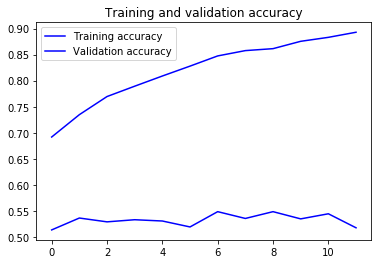

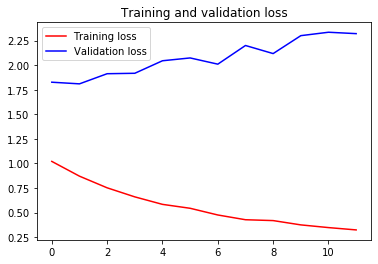

In [45]:
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# let's combine multiple models together
- global average pooling seems not to be working, not sure if the bottleneck features - so here is attempt 2

In [26]:
inception_features = feature_extractor(InceptionV3, inception_preprocess, (128, 128, 3), X_train)
inception_test_features = feature_extractor(InceptionV3, inception_preprocess, (128, 128, 3), X_test)
np.save('./extracted_features/inception_features.npy', inception_features)
np.save('./extracted_features/inception_test_features.npy', inception_test_features)


xception_features = feature_extractor(Xception, xception_preprocess, (128, 128, 3), X_train)
xception_test_features = feature_extractor(Xception, xception_preprocess, (128, 128, 3), X_test)
np.save('./extracted_features/xception_features.npy', xception_features)
np.save('./extracted_features/xception_test_features.npy', xception_test_features)

2045/2045 [==============================] - 222s 108ms/step


# define a sequential model that combines the 3 models we grabbed features for above

In [57]:
# load the data files into the features
inception_features = np.load('./extracted_features/inception_features.npy')
inception_test_features = np.load('./extracted_features/inception_test_features.npy')

xception_features = np.load('./extracted_features/xception_features.npy')
xception_test_features = np.load('./extracted_features/xception_test_features.npy')

res50_features = np.load('./extracted_features/res50_features.npy')
res50_test_features = np.load('./extracted_features/res50_test_features.npy')

def get_final_features(feature_list):
    features = np.concatenate(feature_list, axis=-1)
    print(f'Features Shape: {features.shape}')
    return features

FEATURES = get_final_features([inception_features, xception_features, res50_features])

def get_combo_model():
    model = Sequential()
    model.add(InputLayer(input_shape=FEATURES.shape[1:]))
    print(model.output_shape)

    # dense layer for our 120 dog breeds
    model.add(Dense(120, activation='softmax'))
    print(model.output_shape)

    # return the model
    return model


my_combo_model = get_combo_model()
print(my_combo_model.summary())


Features Shape: (8177, 6144)
(None, 6144)
(None, 120)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 120)               737400    
Total params: 737,400
Trainable params: 737,400
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
# compile the model
my_combo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# best model callback
checkpoint_combo = ModelCheckpoint(filepath='./saved_models/combo_best_weights.hdf5', verbose=1, save_best_only=True)


#fit the model
history = my_combo_model.fit(FEATURES, y_train, epochs=80, batch_size=128, validation_split=.15, callbacks=[early_callback, checkpoint_combo], verbose=1)

Train on 6950 samples, validate on 1227 samples
Epoch 1/80
6950/6950 [==============================] - 2s 258us/step - loss: 3.7058 - accuracy: 0.3629 - val_loss: 2.6455 - val_accuracy: 0.4849

Epoch 00001: val_loss improved from inf to 2.64547, saving model to ./saved_models/combo_best_weights.hdf5
Epoch 2/80
6950/6950 [==============================] - 1s 145us/step - loss: 1.2039 - accuracy: 0.6953 - val_loss: 2.2720 - val_accuracy: 0.5387

Epoch 00002: val_loss improved from 2.64547 to 2.27197, saving model to ./saved_models/combo_best_weights.hdf5
Epoch 3/80
6950/6950 [==============================] - 1s 136us/step - loss: 0.4860 - accuracy: 0.8590 - val_loss: 2.1929 - val_accuracy: 0.5403

Epoch 00003: val_loss improved from 2.27197 to 2.19288, saving model to ./saved_models/combo_best_weights.hdf5
Epoch 4/80
6950/6950 [==============================] - 1s 140us/step - loss: 0.2242 - accuracy: 0.9357 - val_loss: 2.1351 - val_accuracy: 0.5623

Epoch 00004: val_loss improved from

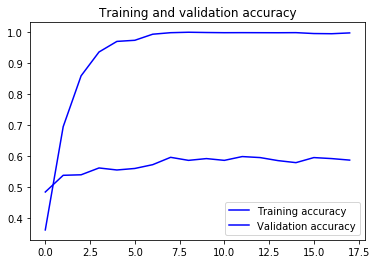

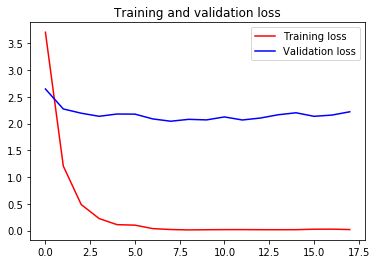

In [59]:
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [62]:
TEST_FEATURES = get_final_features([inception_test_features, xception_test_features, res50_test_features])

score = my_combo_model.evaluate(TEST_FEATURES, y_test, verbose=1)
print('The accuracy is: ', score[1])

Features Shape: (2045, 6144)
2045/2045 [==============================] - 0s 77us/step
The accuracy is:  0.5750611424446106
